In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
import random
import pandas as pd
import heapq
import string
from sklearn.linear_model import LinearRegression, Lasso


pynt=True
if pynt:
    import pynt
    pynt.set_style('pynt')
    pynt.set_fontsize(12)

# Global variables
operations=np.array(["[0]NOT", "[1]NAND", "[2]AND", "[3]ORN", "[4]OR", "[5]ANDN", "[6]NOR", "[7]XOR", "[8]EQU"])

## Instructions
- Caveat: This is a messy notebook from out thesis project and it includes functions that might not work at all
- The functions in this notebook are tools for analyzing results from Avida-AGI
- Data from avida run saves automatically in "./cbuild/work/data/AGIdata/run". It consists of three csv files and a folder: "settings.csv", "metarun.csv" and "chromosomes.csv". The latter is only used for the run itself. The folder is called "meta" and it itself consists of folders "M0", "M1", "M2" and so on. These in turn consist of csv files with names "N0.csv", "N1.csv", "N2.csv" and so on. These contain data for the updates for every world. 
- If you want to save the "run" folder change the name to something so it won't be overwritten. The following functions uses the "run" folder per default but pass another name in the variable "run_name" to change this.


### General functions
- read_settings_data

### Meta evolution analysis
- read_meta_data
- plot_meta_data
- plot_chromosome_convergence
- plot_final_genome
- plot_edit_distances
- decay
- produce_meta_report

### Avida performance analysis
- read_update_data
- plot_update_data
- compare_meta_runs
- plot_strategy_data
- compare_strategies

### Controller evaluation
- phi_c and alignment: old controller fitness functions
- alignment_new: new controller alignment score
- compute_strategy_probabilities
- compute_genome_probabilities
- compute_strategy_fitness
- filter_best_strategies
- plot_strategy_evaluation
- generate_regression_data
- produce_strategy_evaluation




In [2]:
def read_settings_data(run_name="run"):
    df = pd.read_csv(f"./{run_name}/settings.csv")
    return df

In [3]:
def read_meta_data(run_name="run"):

    data = np.genfromtxt(f"./{run_name}/metarun.csv", delimiter=',', skip_header=1)
    m=data[:,0]
    phi_0_max=data[:,1]
    imax=data[:,2]
    chromosome_length = data.shape[1]-3

    hat_phi = np.array([data[:,i] for i in range(3,3+chromosome_length)])
    meta_data = {"m":m, "phi_0_max":phi_0_max, "imax": imax, "chromosome":hat_phi, "chromosome_length":chromosome_length}
    return meta_data

In [4]:
def plot_meta_data(ax, flag=0, task=0, run_name="run"):
    data = read_meta_data(run_name=run_name)
    if flag==0:
        ax.plot(data['m'], data['phi_0_max'])
        ax.set(xlabel='Meta Generation', ylabel=r"Max controller fitness", yscale='linear')
    if flag==1:
        ax.plot(data['m'], data['chromosome'][task])
        ax.set(ylabel="Gene value", xlabel=r'$m$')

In [5]:
def plot_chromosome_convergence(ax, run_name="run"):

    meta_data = read_meta_data(run_name=run_name)
    chromosomes = meta_data["chromosome"]
    chromosome_length = meta_data["chromosome_length"]

    distances = np.empty(chromosomes.shape[1]-1)
    for i in range(chromosomes.shape[1]-1):
        chromosome1 = chromosomes[:,i]
        chromosome2 = chromosomes[:,i+1]

        dist = 0
        for j in range(chromosomes.shape[0]):
            dist += np.abs(chromosome1[j] - chromosome2[j])
        
        distances[i] = dist

    ax.plot(distances)
    ax.set(xlabel="m", ylabel="$|X_{i+1} - X_i|$", title="Chromosome convergence")




In [6]:
def plot_final_genome(ax, run_name="run", inst_set=False):
    data = read_meta_data(run_name=run_name)
    final_chromosome = np.array([d[-1] for d in data['chromosome']])
    chromosome_length = len(final_chromosome)
    #ops = operations[:chromosome_length]
    if inst_set:
        ax.plot(get_instruction_set(), final_chromosome)
    else:
        ax.plot(final_chromosome)
    ax.set(xlabel="Gene", ylabel="Value", title="Final Chromosome")

In [7]:
def plot_edit_distances(ax1, ax2,run_name="run"):
    meta_data = read_meta_data(run_name=run_name)
    chromosomes = meta_data["chromosome"]
    chromosome_length = meta_data["chromosome_length"]

    df = read_settings_data(run_name=run_name)
    b0 = np.empty(chromosome_length)
    for i in range(chromosome_length):
        b0[i] = df[f"ref_bonus[{i}]"][0]

    l, M = chromosomes.shape
    if l != len(b0):
        raise ValueError("chromosomes are not of equal lengths")
        return -1
    
    final_distances = np.empty(l)
    for ix in range(l):
        final_distances[ix] = np.abs(chromosomes[ix,-1] - b0[ix])

    ax1.plot(final_distances, '-o')
    ax1.set(xlabel="gene", ylabel="final edit distance")

    distance = np.empty(M)
    for jx in range(M):
        distance[jx] = np.sum(np.abs(chromosomes[:,jx] - b0))

    ax2.plot(distance, '-o')
    ax2.set(xlabel="m", ylabel="cumulative edit distance")



In [8]:
def decay(m, decay_rate=0.95, constant=25/3, min_constant=0.5):
    return constant*decay_rate**m + min_constant

In [9]:
def produce_meta_report(run_name="run", save_fig=[[True, False, False, True], ["training_curve", "lala", "lala", "chromosome_convergence"]], inst_set=False):
    print("***** REPORT *****")
    
    print("Settings:")
    df = read_settings_data(run_name=run_name)
    display(df)
    gene_min=df[' gene_min'][0]; gene_max=df[' gene_max'][0]
    chromosome_length = read_meta_data(run_name=run_name)["chromosome_length"]
    
    #fig1, axs = plt.subplots(1,2, figsize=(16,2)
    #plot_edit_distances(axs[0], axs[1], run_name=run_name)

    fig1, axs = plt.subplots(1,1, figsize=(16,2)) 
    plot_meta_data(axs, flag=0, run_name=run_name)

    print("Best fitness per meta generation and the corresponding chromosomes")
    fig2, axs = plt.subplots(4,4, figsize=(16,16))
    genes = [j for j in range(0, int(chromosome_length), 1)]
    ix = 0
    for i in range(4):
        for j in range(4):
            if ix >= int(chromosome_length):
                continue
            plot_meta_data(axs[i,j], flag=1, task=genes[ix], run_name=run_name)
            axs[i,j].set(ylim=[gene_min-0.5, gene_max+0.5])
            ix += 1
    fig2.tight_layout()

    fig3, ax = plt.subplots(1,1, figsize=(16,2))
    plot_final_genome(ax, run_name, inst_set=inst_set)
    fig3.tight_layout()
    plt.xticks(rotation=45)

    fig4, ax = plt.subplots(1,1, figsize=(16,2))
    plot_chromosome_convergence(ax, run_name)

    figs = [fig1, fig2, fig3, fig4]

    for i, sf in enumerate(save_fig[0]):
        if sf:
            figs[i].savefig(f"figures/{save_fig[1][i]}.pdf")


 

In [10]:
def read_update_data(M, N, run_name="run"):
    data = np.genfromtxt(f"./{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)

    update=data[:,0]
    gen=data[:,1]
    phi_i=data[:,2]
    phi_0=data[:,3]
    n_orgs=data[:,4]
    num_tasks = read_settings_data(run_name=run_name)["num_tasks"][0]
    num_strategies = read_settings_data(run_name=run_name)["num_strategies"][0]

    tasks = np.array([data[:,i] for i in range(5, 5+num_tasks)])
    strategy = np.array([data[:,i] for i in range(5+num_tasks, 5+num_tasks+num_strategies)])
    bonus_vec_mean = np.array([data[:,i] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    bonus_vec_var = np.array([data[:,i] for i in range(data.shape[1]-num_tasks, data.shape[1])])

    update_data = {"updates": update, "generation": gen, "phi_i":phi_i, "phi_0":phi_0, "n_orgs": n_orgs, "tasks": tasks, "strategy": strategy, "bonus_mean": bonus_vec_mean, "bonus_var": bonus_vec_var}
    return update_data



In [11]:
def plot_update_data(M, N, ax, flag=0, prints=True, run_name="run"):
    data = read_update_data(M, N, run_name=run_name)
    if flag==0:
        #plot phi_0
        ax.plot(data["updates"], data["phi_0"], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel="Human fitness", yscale='log')
        ax.legend()
        temp = data['phi_0']
        if prints: print(f"(m,n)=({M},{N}): Sum of phi_0: {np.sum(temp): .2g}, Phi_0 at last update {temp[-1]} " )
    elif flag==1:
        #plot tasks
        for j in range(len(data["tasks"])):
            ax.plot(data["updates"], data["tasks"][j]/data["n_orgs"], label=f"{operations[j]}")
        ax.legend(ncol=2)
        ax.set(xlabel="updates", ylabel="Fraction of population", title=f"(m,n)=({M},{N})", ylim=[0,1])
        temp=data["tasks"]
        if prints: print(f"(m,n)=({M},{N}): Sum of tasks: {np.sum(np.sum(temp,axis=1)): .2g},\n {np.sum(temp,axis=1):}")
    elif flag==2:
        #plot phi_0 sum
        phi_0_cum_sum = [0]
        for i, phi_0_u in enumerate(data["phi_0"]):
            phi_0_cum_sum.append(phi_0_cum_sum[-1] + phi_0_u)
        ax.plot(data["updates"], phi_0_cum_sum[1:], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel=r"Cumulative sum of $\Phi_0$", yscale="log")
        ax.legend()

    elif flag==3:
        #plot alignment
        
        ax.plot(data["updates"], alignment(data["phi_0"], data["phi_i"]), label=fr"($m,n$)=({M},{N}) ")
        #ax.plot(data["updates"], data["phi_i"], label=fr"($m,n$)=({M},{N}) phi_agi")
        ax.set(xlabel="updates", ylabel=r"Alignment")
        ax.legend()

In [12]:
def compare_meta_runs(M=[0,1,2], N=[0,0,0], run_name="run", save_fig=[False, "tasks"]):
    if len(M) != len(N):
        print("Not same length of N and M")
        return False
    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M)+1, 2, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
    for i in range(1,len(M)+1):
        axs.append(fig.add_subplot(gs[i, :]))
    
    for i, m, n in zip(range(2, len(M)+2), M, N):
        plot_update_data(m, n, axs[0], flag=0, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[1], flag=3, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[i], flag=1, prints=True, run_name=run_name)

    if save_fig[0]:
        print("saving figure")
        fig.savefig(f"figures/{save_fig[1]}.pdf")
        

In [13]:
def plot_strategy_data(M, N, ax, run_name="run"):
# M=1
# N=0
# run_name="run"
# fig, ax = plt.subplots(1,1)

    data = read_update_data(M, N, run_name=run_name)

    for j in range(len(data["strategy"])):
        ax.plot(data["updates"], data["strategy"][j], label=j)
    ax.legend(ncol=2)
    ax.set(xlabel="Update", ylabel="Strategy", title=f"(m,n)=({M},{N})")

In [14]:
def compare_strategies(M=[0,1,2], N=[0,0,0], run_name="run"):
# M=[0,1,2]
# N=[0,0,0]
# run_name="run"

    if len(M) != len(N):
        print("Not same length of N and M")
        #return False

    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M), 1, figure=fig)
    axs = []
    for i in range(0, len(M)):
        axs.append(fig.add_subplot(gs[i, :]))

    for i, m, n in zip(range(0, len(M)), M, N):
        plot_strategy_data(m, n, axs[i], run_name=run_name)

In [15]:
def phi_c(phi_h, phi_agi):
    return phi_h*1/(np.abs(np.log(phi_agi/phi_h))+1)

def alignment(phi_h, phi_agi):
    return 1/(np.abs(np.log(phi_agi/phi_h))+1)

def alignment_new(M, N, run_name="run", num_tasks=3, ref_bonus=[5,3,1], align_weight=10, align_range=4):
    data = np.genfromtxt(f"{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)
    bvml = np.array([data[:,i][-1] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    norm=align_range
    delta = sum(((bvml-ref_bonus)/norm)**2)/(num_tasks)
    return np.exp(-align_weight*delta)
    #return 1/(1+align_weight*sum(abs(bonus_vec_mean_last-ref_bonus)**2)/(align_range**2)/num_tasks)

def alignment_new_full(M, N, run_name="run", num_tasks=3, ref_bonus=[5,3,1], align_weight=10, align_range=4):
    data = np.genfromtxt(f"{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)
    bonus_vec_mean_last = np.array([data[:,i] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    norm = np.array([4,4,4])
    #print( [(bvml-ref_bonus)/norm for bvml in bonus_vec_mean_last.transpose()])
    delta = np.array([sum(((bvml-ref_bonus)/norm)**2)/(num_tasks) for bvml in bonus_vec_mean_last.transpose()])
    #print(delta)
    return np.exp(-align_weight*delta)
    #np.array([1/(1-sum(((bvml-ref_bonus)/norm)**2)/(num_tasks)) for bvml in bonus_vec_mean_last.transpose()])

In [16]:
def compute_strategy_probabilities(update_data, scaling):
    
    if scaling == "mean":
        frequencies = np.mean(update_data["strategy"], axis=1)
        frequencies = np.around(frequencies, 0).astype(int)

    elif scaling == "prob":
        frequencies = np.sum(update_data["strategy"], axis=1)
        if np.sum(frequencies) > 1: frequencies = frequencies/np.sum(frequencies)
        frequencies = np.around(frequencies, 2)
    
    elif scaling == "count":
        frequencies = np.sum(update_data["strategy"], axis=1)
        frequencies = np.around(frequencies, 0).astype(int)

    
    return tuple(frequencies)



def compute_genome_probabilities(path, num_inst, scaling):

    letters = string.ascii_uppercase[:num_inst]
    freqs = {'A':0, 'B':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'J':0, 'K':0, 'L':0, 'M':0, 'N':0, 'O':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'U':0, 'V':0, 'W':0, 'X':0, 'Y':0, 'Z':0, 'a':0, 'b':0, 'c':0, 'd':0, 'e':0, 'f':0, 'g':0, 'h':0, 'i':0, 'j':0, 'k':0, 'l':0, 'm':0, 'n':0, 'o':0, 'p':0, 'q':0, 'r':0, 's':0, 't':0, 'u':0, 'v':0, 'w':0, 'x':0, 'y':0, 'z':0, '0':0, '1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, ':':0, '(':0, ')':0, '.':0, '#':0, ',':0, '\n':0, '_':0, ' ':0, '-':0, '+':0}

    with open(path, 'r') as f:
        for line in range(15):
            f.readline()
        contents = f.read()
        for char in contents:
            freqs[char] += 1

    counts = 0
    new_freqs = {}
    for key in letters:
        new_freqs[key] = freqs[key]
        counts += new_freqs[key]
    if counts == 0: counts = 1

    if scaling == "mean":
        num_lines = sum(1 for line in open(path))
        new_freqs = {key: new_freqs[key]/num_lines for key in new_freqs}
    elif scaling == "prob":
        new_freqs = {key: new_freqs[key]/counts for key in new_freqs}

    freqs = tuple([round(new_freqs[key], 2) for key in new_freqs.keys()])
    return freqs


def compute_strategy_fitness(run_name, strategy_or_genome, scaling):

    settings = read_settings_data(run_name)
    M = settings["M"].values[0]
    N = settings["N"].values[0]
    U = settings["U"].values[0]
    strategy_length = settings["num_strategies"].values[0]
    stratdict = {}
    countdict = {}

    for m in range(M):
        for n in range(N):
            data = read_update_data(m,n,run_name)
            alignment_score = alignment_new(m, n, run_name=run_name, num_tasks=3, ref_bonus=[5,3,1], align_weight=10, align_range=4)
            fitness = data["phi_0"][-1]*alignment_score
            #fitness = read_meta_data(run_name=run_name)["phi_0_max"][m]*alignment_score
            #print(f"m = {m}, n = {n}, updatefitness = {fitness1}, metafitness = {fitness}")
            
            tasks = [data['tasks'][i]/data["n_orgs"] for i in range(len(data["tasks"]))]
            useful_factor = np.sum([1 if t[-1]>0.5 else 0 for t in tasks])
            value = [fitness, alignment_score, useful_factor]
            path = run_name+"/meta/M"+str(m)+"/N"+str(n)+"/pop"+str(U)

            if strategy_or_genome == "strategy":
                stratdist = compute_strategy_probabilities(data, scaling)
            else:
                stratdist = compute_genome_probabilities(path, strategy_length, scaling)

            if not stratdist in stratdict:
                stratdict[stratdist] = value
                countdict[stratdist] = 1
            else:
                stratdict[stratdist][0] += value[0]
                stratdict[stratdist][1] += value[1]
                stratdict[stratdist][2] += value[2]
                countdict[stratdist] += 1

    for key in stratdict:
        stratdict[key][0] /= countdict[key]
        stratdict[key][1] /= countdict[key]
        stratdict[key][2] /= countdict[key]

    #print("Sampling frequency:")
    #print(countdict.values())

    return stratdict, strategy_length




def filter_best_strategies(k, strat_data):
    data = dict(heapq.nlargest(k, strat_data.items(), key=lambda i: i[1][0]))
    data = {k: v for k, v in data.items() if pd.Series(v).notna().all()}

    return data


def plot_strategy_evaluation(data, run_name, savefig=False):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    x_min=0.8; x_max=1.0; y_min=4; y_max=5.0
    #ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r--', label="_nolegend_")
    num_tasks = read_settings_data(run_name)["num_tasks"].values[0]
    ax.set(xlim=(-0.2, 1.2), ylim=(-0.2, num_tasks+0.2), xlabel="Alignment", ylabel="Usefulness", title="Strategy evaluation")

    for i, (strategy, score) in enumerate(data.items()):
        ax.scatter(score[1], score[2]) 
    ax.legend(data.keys(), bbox_to_anchor=(1.0, 1.0))

    if savefig:
        fig.savefig("figures/strategy_evaluation.pdf")


def generate_regression_data(stratdict, strategy_length):
    names = [i for i in range(strategy_length)]
    names.append("fitness")
    names.append("alignment")
    names.append("usefulness")
    df = pd.DataFrame(columns=names, index=np.arange(len(stratdict)))
    i = 0
    for key in stratdict:
        for j, item in enumerate(key):
            df.iloc[i,j] = item
        df.iloc[i,-3] = stratdict[key][0]
        df.iloc[i,-2] = stratdict[key][1]
        df.iloc[i,-1] = stratdict[key][2]
        i += 1  

    return df


def produce_strategy_evaluation(run_name, strategy_limit, strategy_or_genome, scaling="mean", savefig=False):
    strategy_data, strategy_length = compute_strategy_fitness(run_name, strategy_or_genome, scaling)
    filtered_data = filter_best_strategies(strategy_limit, strategy_data)

    sorted_dict = {}
    sorted_keys = sorted(strategy_data, key=strategy_data.get, reverse=True)  # [1, 3, 2]
    for w in sorted_keys:
        sorted_dict[w] = strategy_data[w]
    strategy_data = sorted_dict

    print("Best strategies:")
    for key in filtered_data:
        print(f"Strategy: {key}, Controller fitness: {filtered_data[key][0]}")
    plot_strategy_evaluation(filtered_data, run_name, savefig)

    reg_data = generate_regression_data(strategy_data, strategy_length)
   #reg_data.iloc[:,:].dropna(inplace=True)
    X = reg_data.iloc[:,:-3]
   #y = reg_data[["alignment", "usefulness"]]
    y = reg_data["fitness"]
    reg = Lasso().fit(X, y)

    print("Regression results:")
    print(f"R2 = {reg.score(X, y)}")
    print("Coefficients:")
    print(reg.coef_.round(1))

    return strategy_data





***** REPORT *****
Settings:


,N,M,U,tournament_probability,crossover_probability,mutation_probability,mutation_probability_constant,mutation_decay,min_mutation_constant,gene_min,...,ref_bonus[0],ref_bonus[1],ref_bonus[2],num_tasks,num_strategies,Phi0_function,Phi0_penalty_factor,dangerous_operations,task_perform_penalty_threshold,random_meta_seed
0,10,4,4000,0.8,0.3,0.111111,2.0,0.8,0.7,0.0,...,5.0,3.0,1.0,3,18,static,0.00001,-1,0.05,imeta


Best fitness per meta generation and the corresponding chromosomes
'lmroman6-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman6-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
(m,n)=(0,0): Sum of phi_0:  1.7e+04, Phi_0 at last update 6.568708 
(m,n)=(0,0): Sum of tasks:  8.2e+06,
 [8245447.       0.       0.]
(m,n)=(1,0): Sum of phi_0:  1.5e+04, Phi_0 at last update 6.243002 
(m,n)=(1,0): Sum of tasks:  7.5e+06,
 [7529600.       0.       0.]
(m,n)=(2,0): Sum of phi_0:  9e+02, Phi_0 at last update 0.212036 
(m,n)=(2,0): Sum of tasks:  0,
 [0. 0. 0.]
(m,n)=(3,0): Sum of phi_0:  9e+04, Phi_0 at last update 46.135159 
(m,n)=(3,0): Sum of tasks:  1.3e+07,
 [7326388. 6044248.       0.]


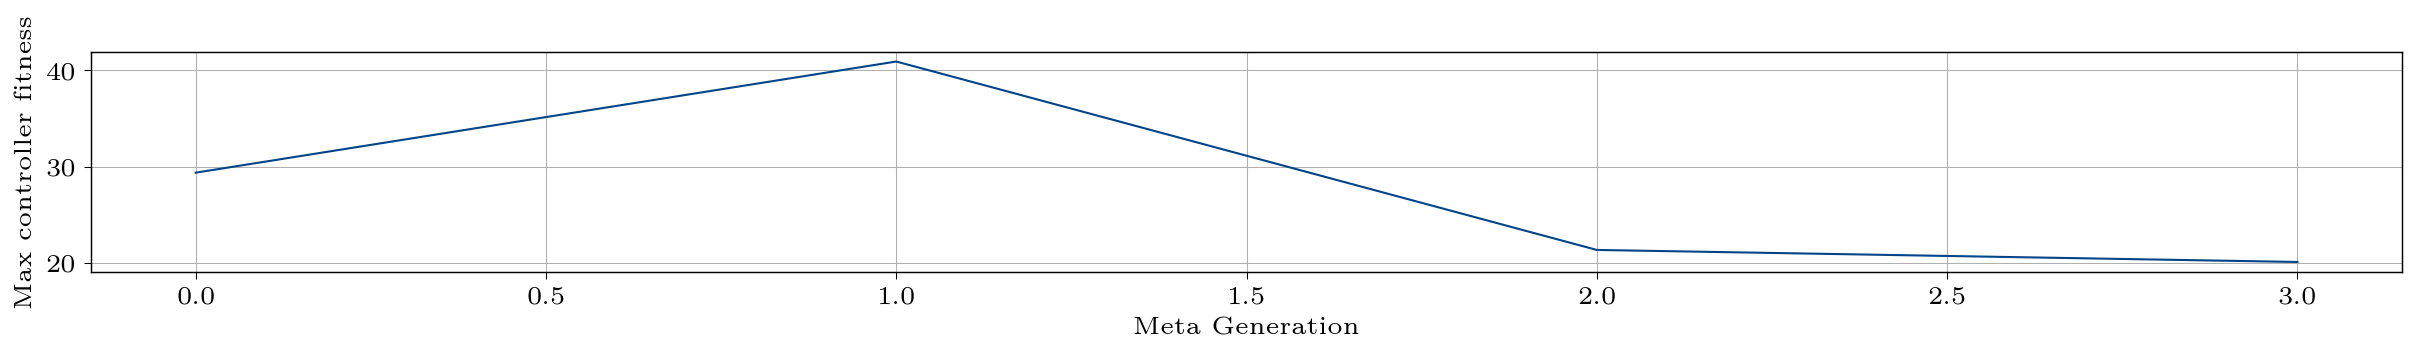

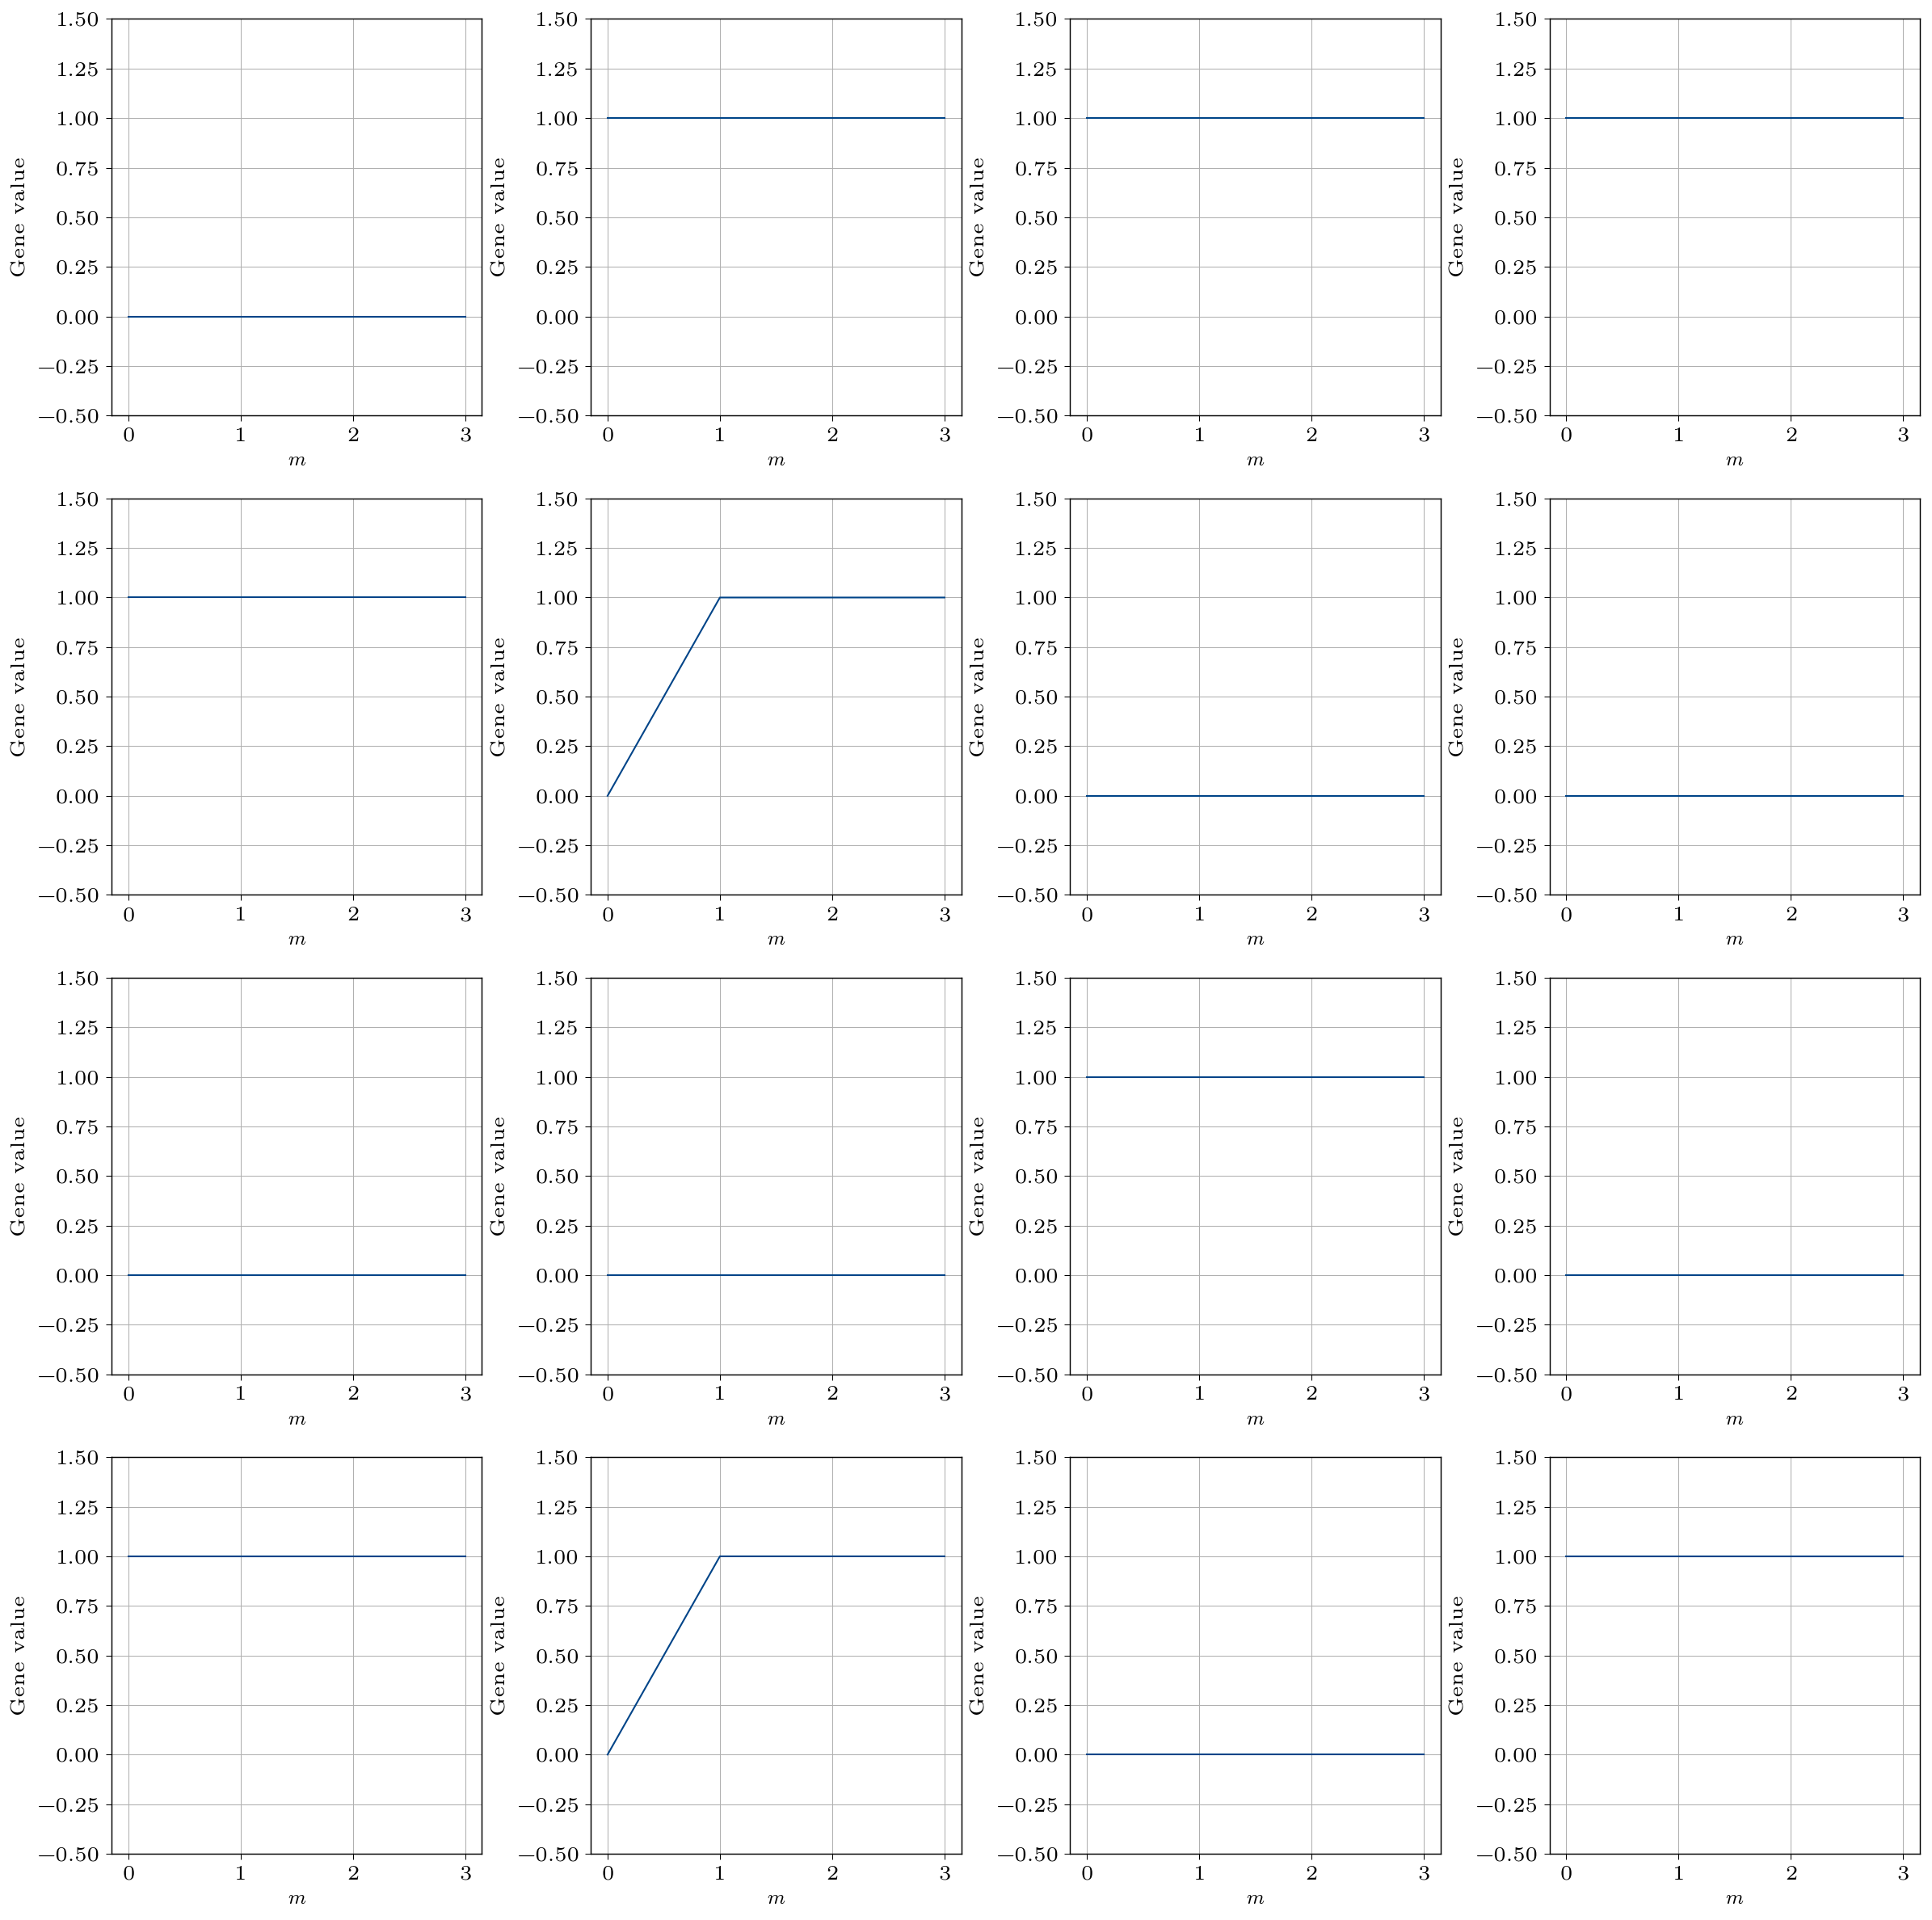

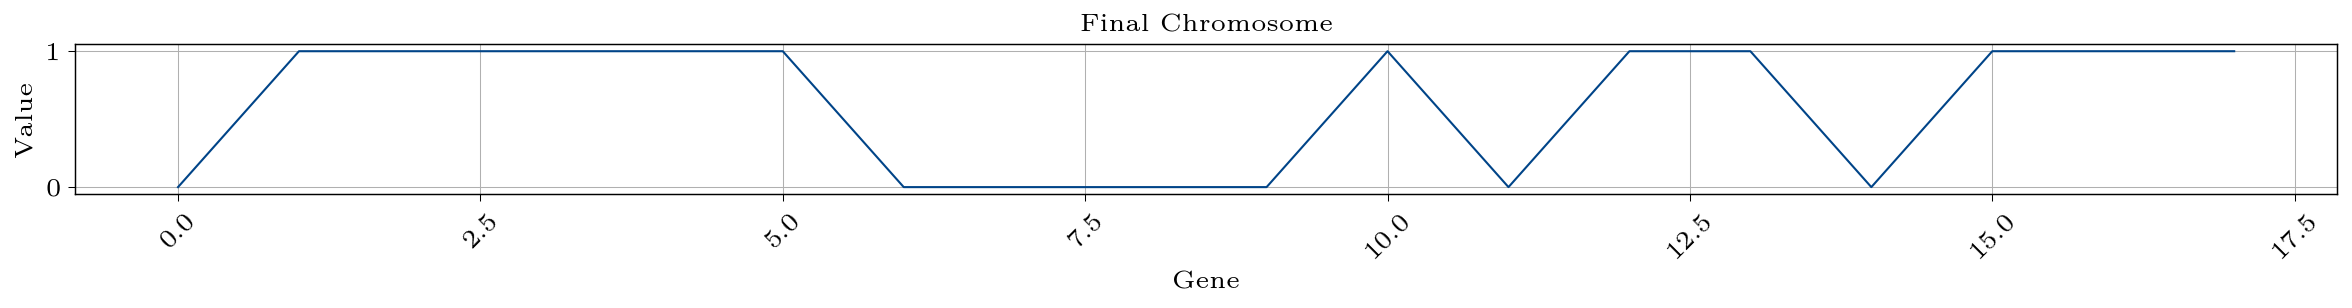

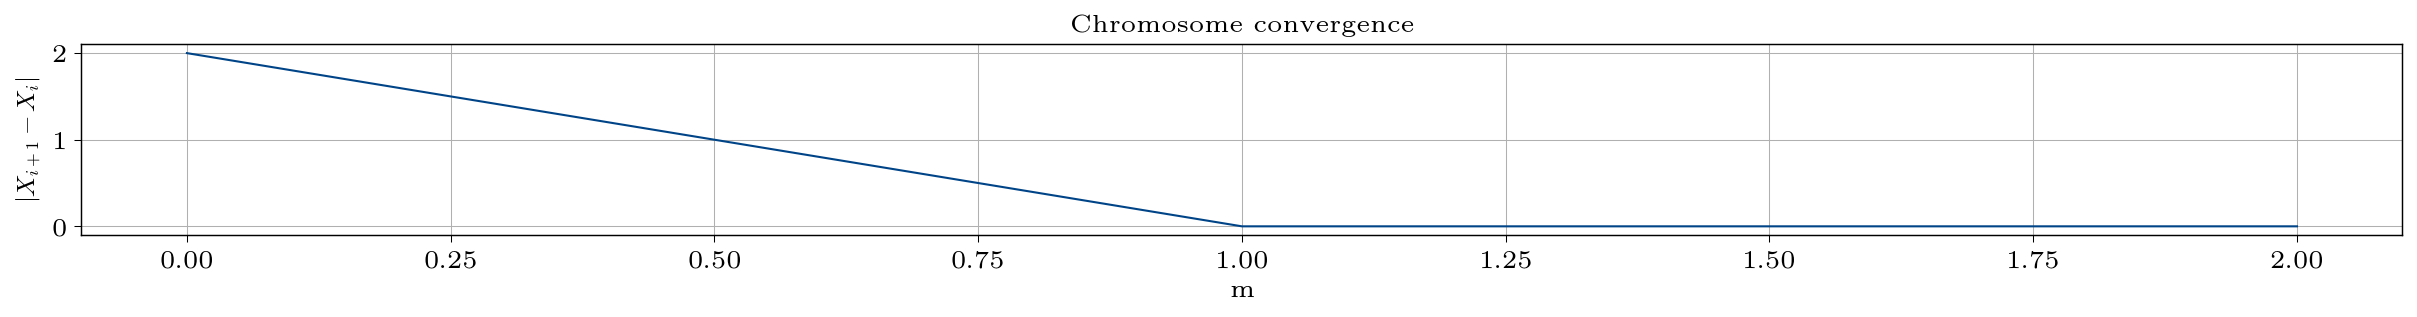

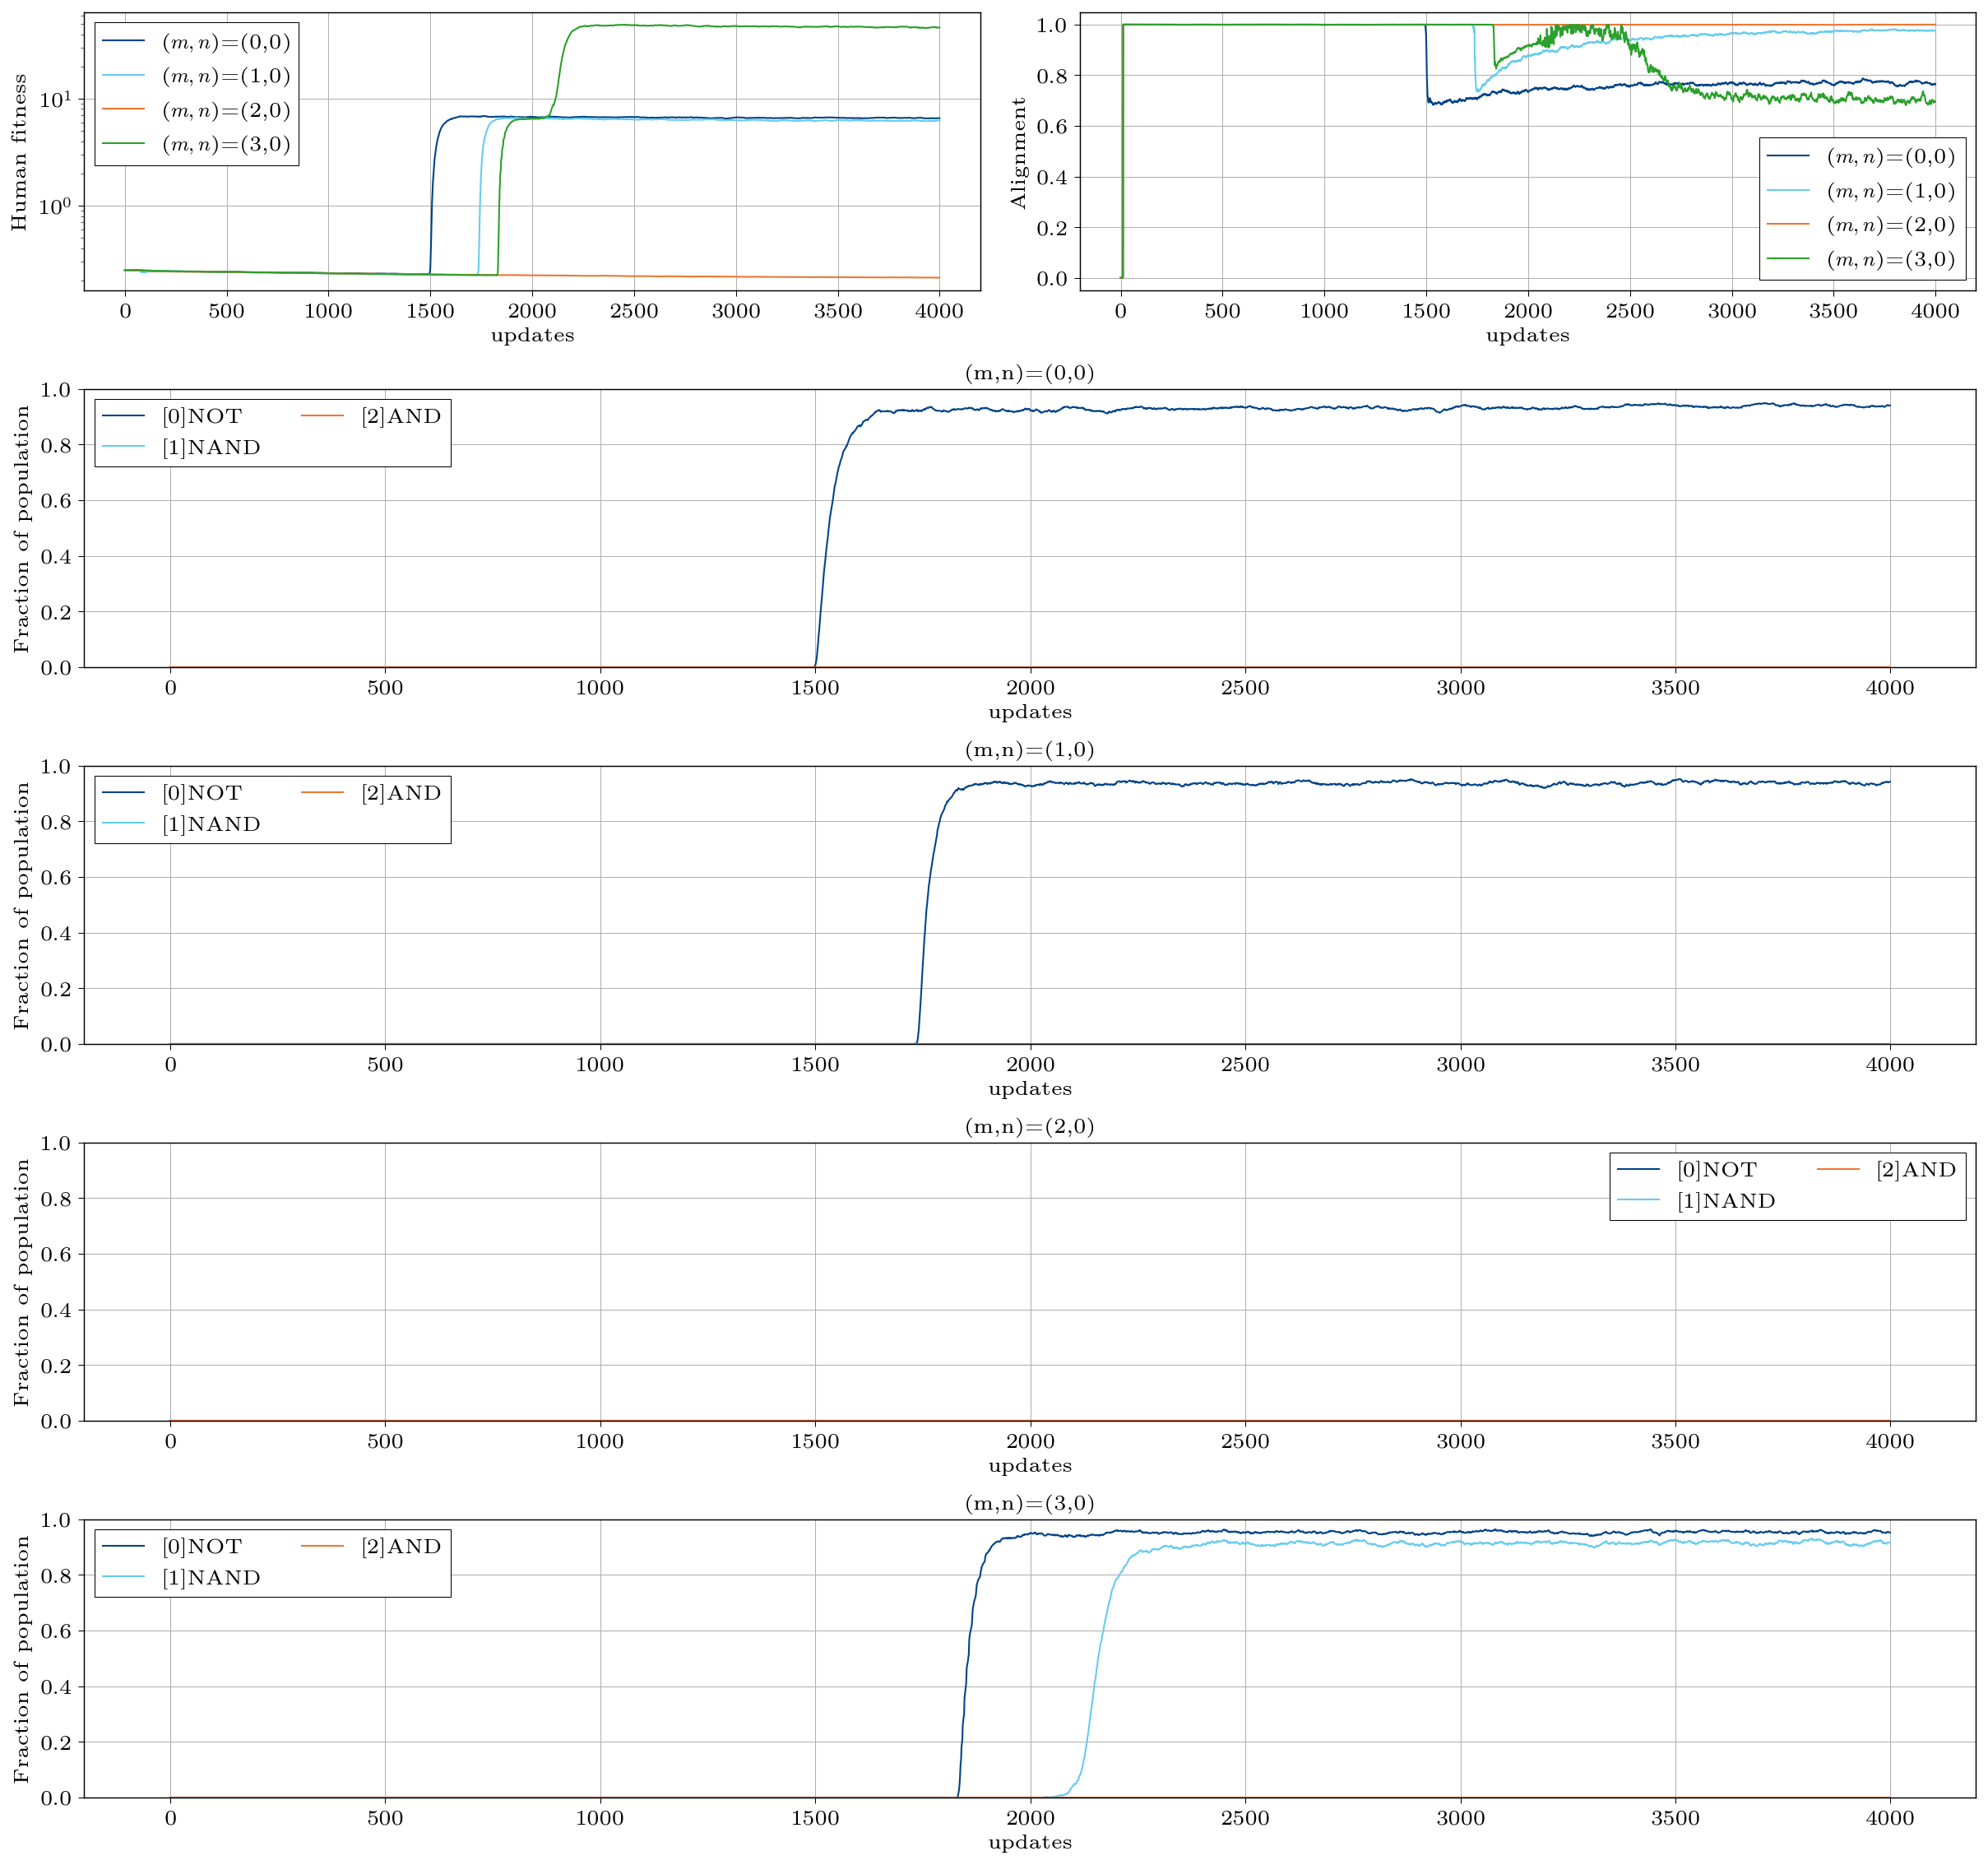

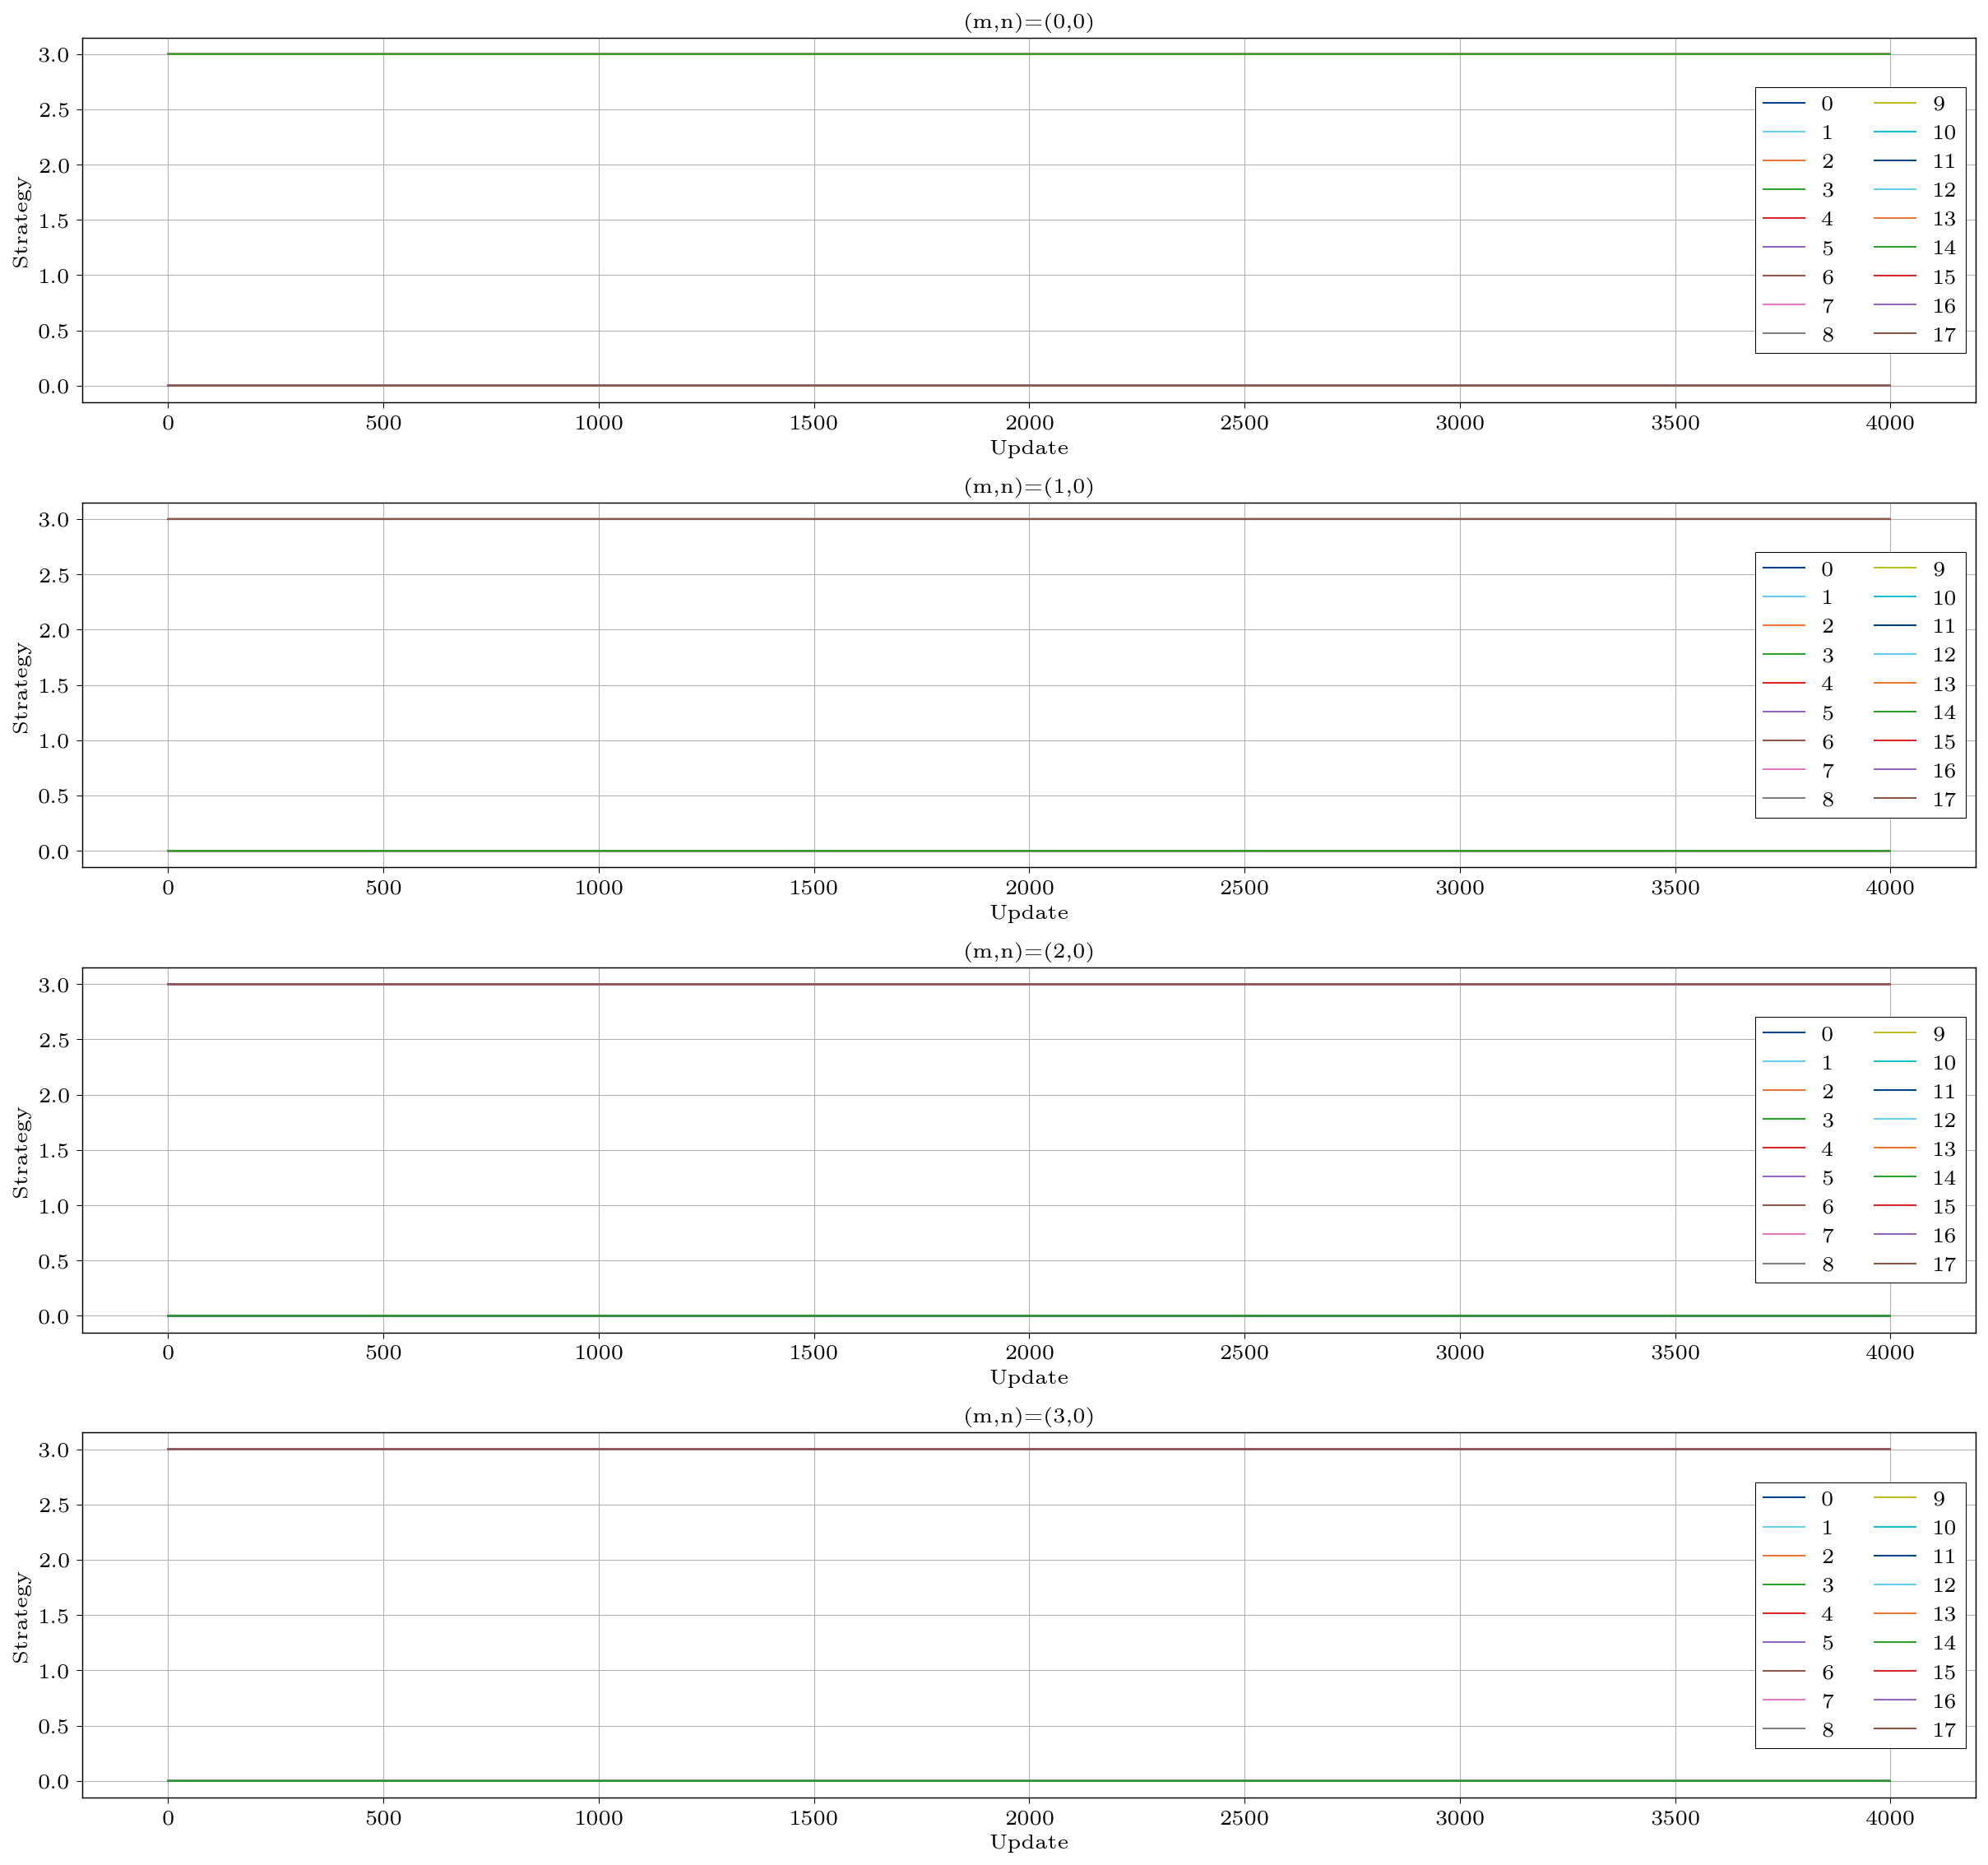

In [17]:
run_name = "cbuild/work/data/AGIdata/run"
M = [i for i in [0,1,2,3]]
N = [0 for i in range(len(M))]

produce_meta_report(run_name=run_name)
compare_meta_runs(M=M, N=N, run_name=run_name) #, save_fig=[True, "tasks_02_25"])
compare_strategies(M=M, N=N, run_name=run_name)


Best strategies:
Strategy: (0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3), Controller fitness: 29.774767930837985
Strategy: (0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 3, 3), Controller fitness: 29.291954974414672
Strategy: (0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3), Controller fitness: 21.38782172136325
Strategy: (0, 3, 3, 0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3), Controller fitness: 20.175084736276244
Strategy: (0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0), Controller fitness: 20.018868481559473
Strategy: (0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3, 3), Controller fitness: 13.48368474285001
Strategy: (0, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3, 0, 3), Controller fitness: 7.238182719751904
Strategy: (0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3), Controller fitness: 6.825637114173036
Strategy: (3, 3, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3), Controller fitness: 5.609157666590956
Strategy: (0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3,

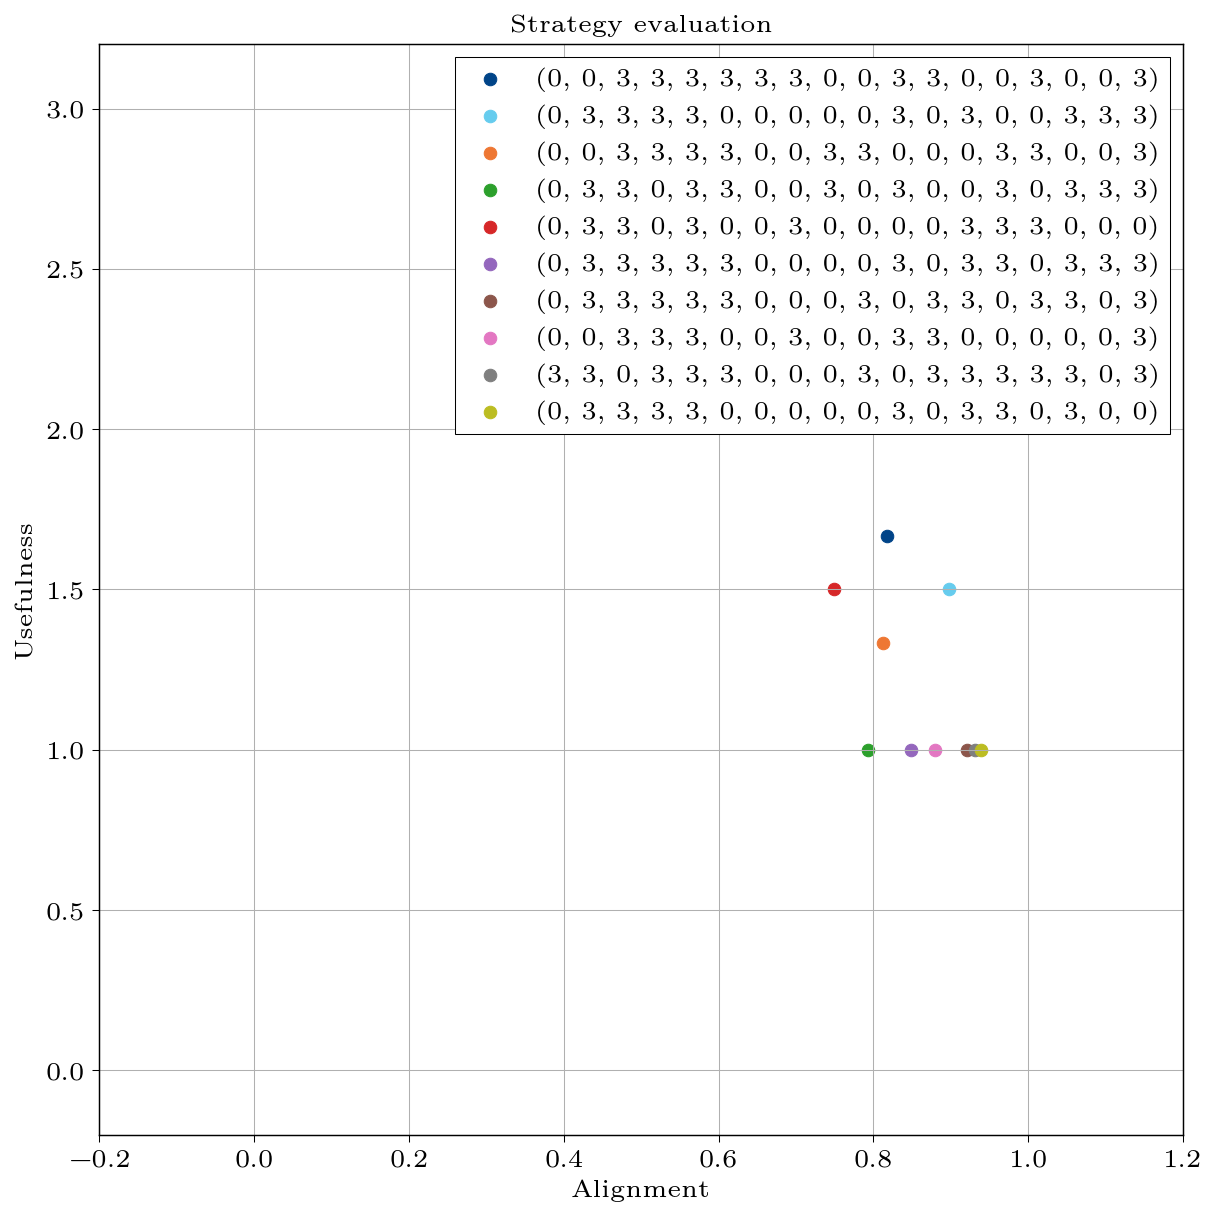

In [18]:
run_name = "cbuild/work/data/AGIdata/run"
strategy_limit = 10
scaling = "mean"
strategy_or_genome = "strategy"
data_strat = produce_strategy_evaluation(run_name, strategy_limit, strategy_or_genome, scaling=scaling)

Best strategies:
Strategy: (0.0, 0.0, 3.99, 3.72, 3.07, 2.46, 0.0, 0.0, 3.95, 5.29, 0.0, 0.0, 0.0, 7.49, 7.06, 0.0, 0.0, 12.93), Controller fitness: 58.39853022077244
Strategy: (0.0, 6.34, 2.84, 9.12, 6.78, 0.0, 0.0, 0.0, 0.0, 0.0, 9.46, 0.0, 3.85, 0.0, 0.0, 5.29, 6.3, 3.49), Controller fitness: 53.173095837037394
Strategy: (0.0, 0.0, 2.9, 6.75, 6.47, 7.78, 6.62, 6.95, 0.0, 0.0, 5.81, 8.0, 0.0, 0.0, 5.71, 0.0, 0.0, 7.91), Controller fitness: 47.290156990187434
Strategy: (0.0, 10.44, 6.96, 0.0, 8.21, 7.28, 0.0, 0.0, 9.3, 0.0, 3.57, 0.0, 0.0, 12.18, 0.0, 4.03, 2.93, 4.88), Controller fitness: 40.196996605870794
Strategy: (0.0, 0.0, 5.67, 8.04, 6.62, 4.5, 3.92, 2.37, 0.0, 0.0, 4.97, 3.13, 0.0, 0.0, 5.33, 0.0, 0.0, 3.08), Controller fitness: 36.46129455491694
Strategy: (0.0, 6.8, 7.61, 0.0, 6.33, 0.0, 0.0, 6.81, 0.0, 0.0, 0.0, 0.0, 3.63, 6.15, 4.35, 0.0, 0.0, 0.0), Controller fitness: 35.01195579854365
Strategy: (0.0, 1.73, 2.58, 7.42, 5.88, 3.93, 0.0, 0.0, 0.0, 0.0, 4.24, 0.0, 3.78, 5.51,

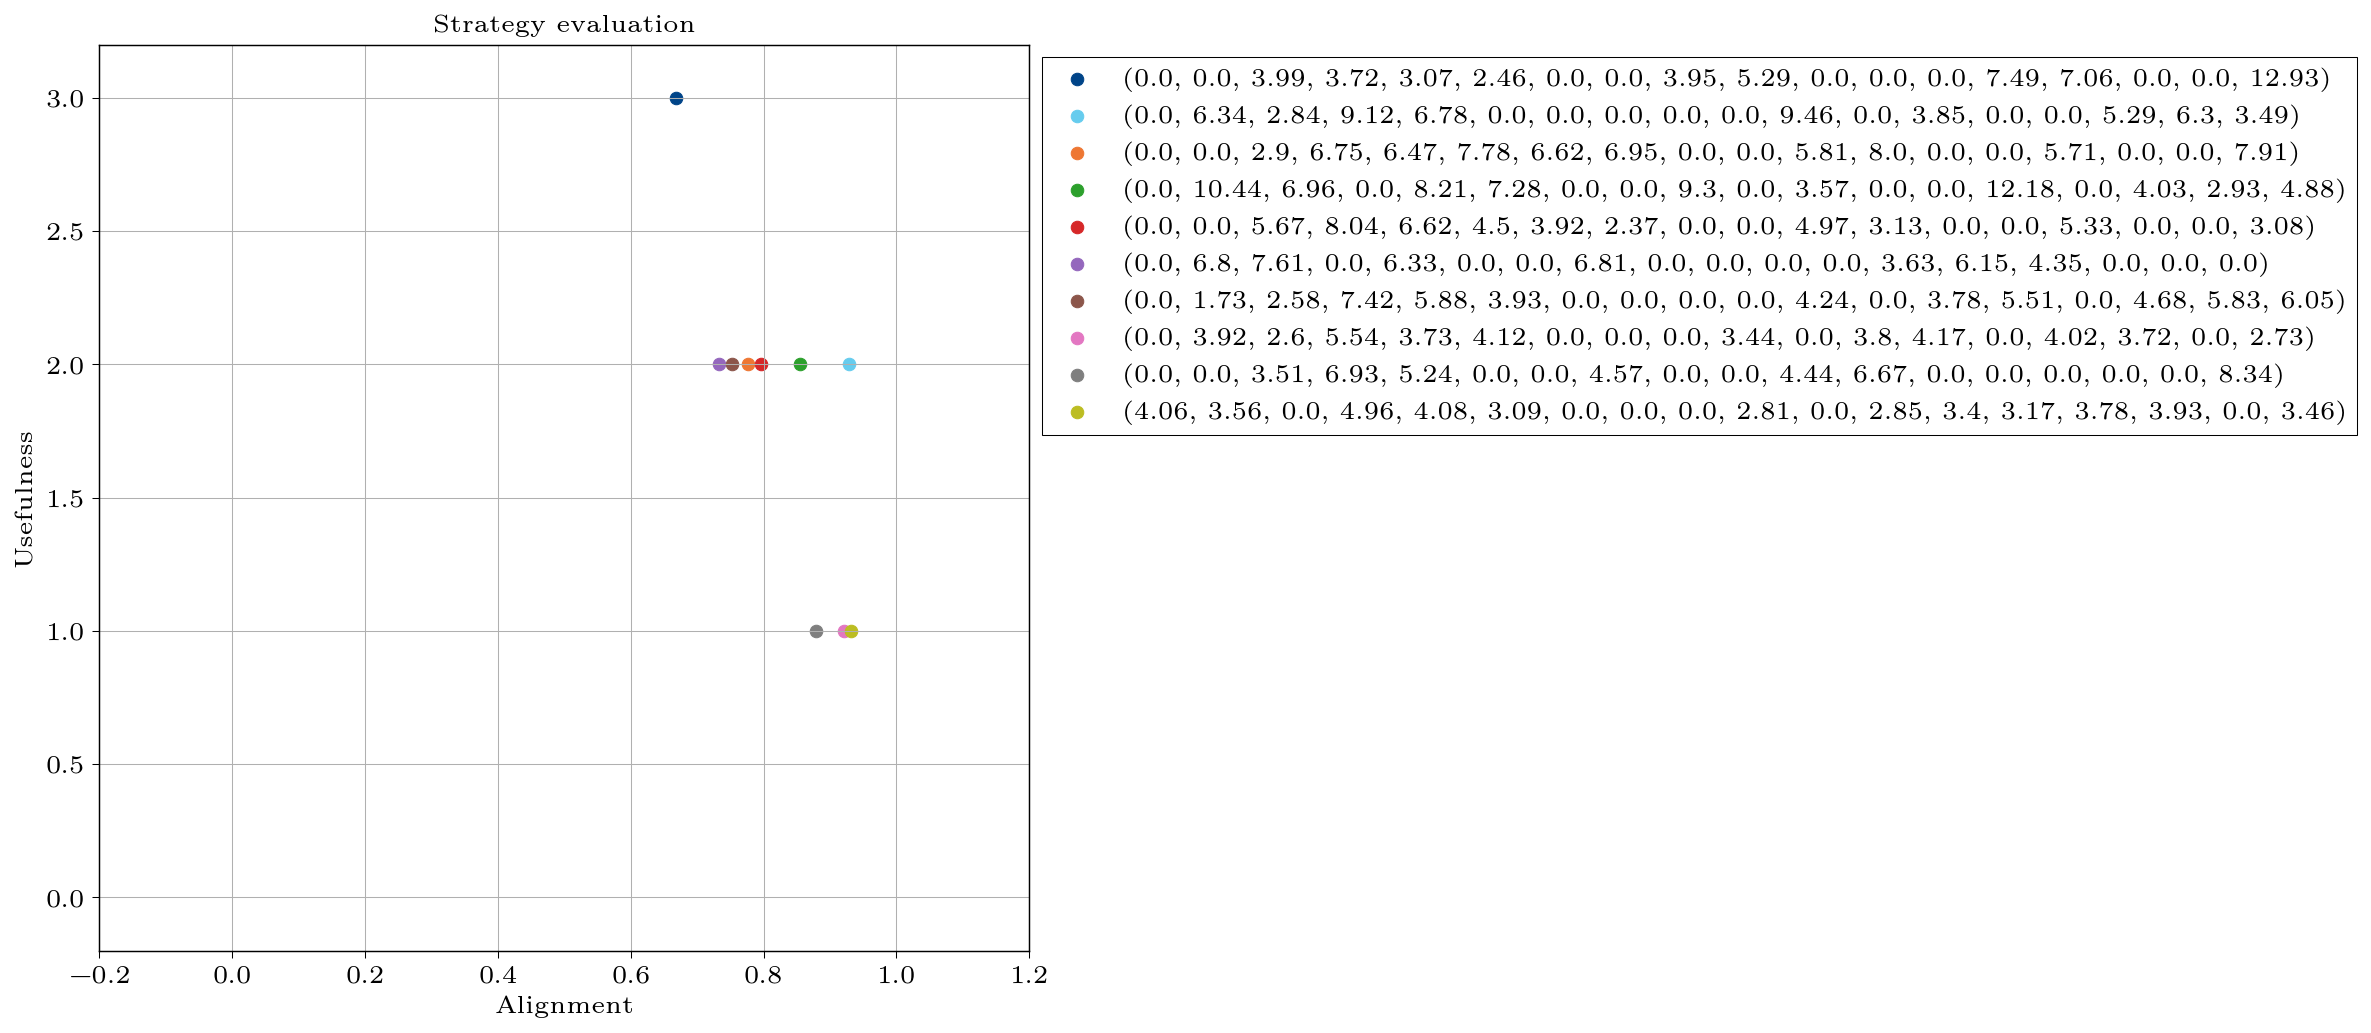

In [19]:
run_name = "cbuild/work/data/AGIdata/run"
strategy_limit = 10
scaling = "mean"
strategy_or_genome = "genome"
data_gen = produce_strategy_evaluation(run_name, strategy_limit, strategy_or_genome, scaling=scaling)